## **Under Water Image Enhancement By SRCNN**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import cv2 
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input,decode_predictions
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.models import Model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from google.colab.patches import cv2_imshow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
import argparse
from IPython.display import display
import scipy as sp
import scipy.ndimage
import PIL.Image as Image
import skimage.io as io
import time
from numba import jit


## **Retinex Algorithm is used to defogging the image**

In [ ]:
def retinex_scales_distribution(max_scale, nscales):
    scales = []
    scale_step = max_scale / nscales
    for s in range(nscales):
        scales.append(scale_step * s + 2.0)
    return scales


def CR(im_ori, im_log, alpha=128., gain=1., offset=0.):
    im_cr = im_log * gain * (
            np.log(alpha * (im_ori + 1.0)) - np.log(np.sum(im_ori, axis=2) + 3.0)[:, :, np.newaxis]) + offset
    return im_cr


def MSRCR(image_path, max_scale, nscales, dynamic=2.0, do_CR=True):
    im_ori = np.float32(cv2.imread(image_path)[:, :, (2, 1, 0)])
    scales = retinex_scales_distribution(max_scale, nscales)

    im_blur = np.zeros([len(scales), im_ori.shape[0], im_ori.shape[1], im_ori.shape[2]])
    im_mlog = np.zeros([len(scales), im_ori.shape[0], im_ori.shape[1], im_ori.shape[2]])

    for channel in range(3):
        for s, scale in enumerate(scales):
            # If sigma==0, it will be automatically calculated based on scale
            im_blur[s, :, :, channel] = cv2.GaussianBlur(im_ori[:, :, channel], (0, 0), scale)
            im_mlog[s, :, :, channel] = np.log(im_ori[:, :, channel] + 1.) - np.log(im_blur[s, :, :, channel] + 1.)

    im_retinex = np.mean(im_mlog, 0)
    if do_CR:
        im_retinex = CR(im_ori, im_retinex)

    im_rtx_mean = np.mean(im_retinex)
    im_rtx_std = np.std(im_retinex)
    im_rtx_min = im_rtx_mean - dynamic * im_rtx_std
    im_rtx_max = im_rtx_mean + dynamic * im_rtx_std

    im_rtx_range = im_rtx_max - im_rtx_min

    im_out = np.uint8(np.clip((im_retinex - im_rtx_min) / im_rtx_range * 255.0, 0, 255))

    return im_out


## **Load all the images here**

In [ ]:
image_path = '/content/drive/MyDrive/AI Assignment/input/challenging-60'
import tensorflow as tf

def loadImages(path):
    
    image_files = sorted([os.path.join(path, file)
                          for file in os.listdir(path)
                          if file.endswith('.png')])
    return image_files

/content/drive/MyDrive/AI Assignment/input/challenging-60/10226.png


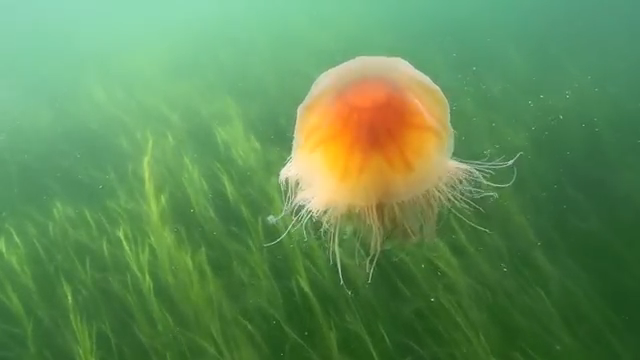

In [ ]:
#load images path
img_dataset=loadImages(image_path)
image1=img_dataset[5]
print(image1)
img=np.float32(cv2.imread(image1))
Orignal_img=img
cv2_imshow(img)


# 1.Applying Retinex Algorithm MSRCR to defog the images

# 2.then Applied with gamma correction to adjust the image brightness 

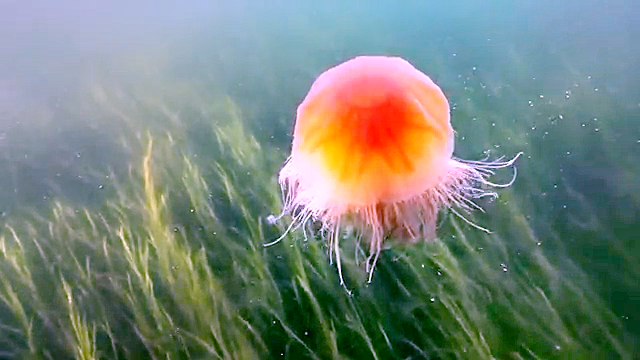

In [ ]:
 
image_path=image1
im_out = MSRCR(image_path, max_scale=300, nscales=3, dynamic=2.0, do_CR=True)
im_out=im_out[:, :, (2, 1, 0)]
img_gamma = np.array(255*(im_out / 255) ** (0.7), dtype = 'uint8')
cv2_imshow( im_out)
cv2_imshow(img_gamma)

## Output After Retinex and gamma Algoritm applied on All images

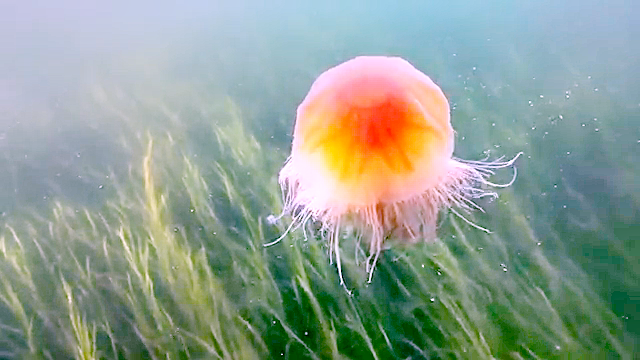

In [ ]:
aft=img_gamma
cv2_imshow(aft)

# Now Apply the Dark Prior to image to remove the haze from it

In [ ]:
def box(img, r):
   
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst

In [ ]:
def _gf_color(I, p, r, eps, s=None):
  
    fullI = I
    fullP = p
    if s is not None:
        I = sp.ndimage.zoom(fullI, [1/s, 1/s, 1], order=1)
        p = sp.ndimage.zoom(fullP, [1/s, 1/s], order=1)
        r = round(r / s)

    h, w = p.shape[:2]
    N = box(np.ones((h, w)), r)

    mI_r = box(I[:,:,0], r) / N
    mI_g = box(I[:,:,1], r) / N
    mI_b = box(I[:,:,2], r) / N

    mP = box(p, r) / N

    # mean of I * p
    mIp_r = box(I[:,:,0]*p, r) / N
    mIp_g = box(I[:,:,1]*p, r) / N
    mIp_b = box(I[:,:,2]*p, r) / N

    # per-patch covariance of (I, p)
    covIp_r = mIp_r - mI_r * mP
    covIp_g = mIp_g - mI_g * mP
    covIp_b = mIp_b - mI_b * mP

    # symmetric covariance matrix of I in each patch:
    var_I_rr = box(I[:,:,0] * I[:,:,0], r) / N - mI_r * mI_r;
    var_I_rg = box(I[:,:,0] * I[:,:,1], r) / N - mI_r * mI_g;
    var_I_rb = box(I[:,:,0] * I[:,:,2], r) / N - mI_r * mI_b;

    var_I_gg = box(I[:,:,1] * I[:,:,1], r) / N - mI_g * mI_g;
    var_I_gb = box(I[:,:,1] * I[:,:,2], r) / N - mI_g * mI_b;

    var_I_bb = box(I[:,:,2] * I[:,:,2], r) / N - mI_b * mI_b;

    a = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            sig = np.array([
                [var_I_rr[i,j], var_I_rg[i,j], var_I_rb[i,j]],
                [var_I_rg[i,j], var_I_gg[i,j], var_I_gb[i,j]],
                [var_I_rb[i,j], var_I_gb[i,j], var_I_bb[i,j]]
            ])
            covIp = np.array([covIp_r[i,j], covIp_g[i,j], covIp_b[i,j]])
            a[i,j,:] = np.linalg.solve(sig + eps * np.eye(3), covIp)

    b = mP - a[:,:,0] * mI_r - a[:,:,1] * mI_g - a[:,:,2] * mI_b

    meanA = box(a, r) / N[...,np.newaxis]
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, [s, s, 1], order=1)
        meanB = sp.ndimage.zoom(meanB, [s, s], order=1)

    q = np.sum(meanA * fullI, axis=2) + meanB

    return q

In [ ]:
def _gf_gray(I, p, r, eps, s=None):

    if s is not None:
        Isub = sp.ndimage.zoom(I, 1/s, order=1)
        Psub = sp.ndimage.zoom(p, 1/s, order=1)
        r = round(r / s)
    else:
        Isub = I
        Psub = p


    (rows, cols) = Isub.shape

    N = box(np.ones([rows, cols]), r)

    meanI = box(Isub, r) / N
    meanP = box(Psub, r) / N
    corrI = box(Isub * Isub, r) / N
    corrIp = box(Isub * Psub, r) / N
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP


    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = box(a, r) / N
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, s, order=1)
        meanB = sp.ndimage.zoom(meanB, s, order=1)

    q = meanA * I + meanB
    return q

In [ ]:

def _gf_colorgray(I, p, r, eps, s=None):
   
    if I.ndim == 2 or I.shape[2] == 1:
        return _gf_gray(I, p, r, eps, s)
    elif I.ndim == 3 and I.shape[2] == 3:
        return _gf_color(I, p, r, eps, s)
    else:
        print()


def guided_filter(I, p, r, eps, s=None):

    if p.ndim == 2:
        p3 = p[:,:,np.newaxis]

    out = np.zeros_like(p3)
    for ch in range(p3.shape[2]):
        out[:,:,ch] = _gf_colorgray(I, p3[:,:,ch], r, eps, s)
    return np.squeeze(out) if p.ndim == 2 else out

In [ ]:
def test_gf():
    import imageio
    cat = imageio.imread('cat.bmp').astype(np.float32) / 255
    tulips = imageio.imread('tulips.bmp').astype(np.float32) / 255

    r = 8
    eps = 0.05

    cat_smoothed = guided_filter(cat, cat, r, eps)
    cat_smoothed_s4 = guided_filter(cat, cat, r, eps, s=4)

    imageio.imwrite('cat_smoothed.png', cat_smoothed)
    imageio.imwrite('cat_smoothed_s4.png', cat_smoothed_s4)

    tulips_smoothed4s = np.zeros_like(tulips)
    for i in range(3):
        tulips_smoothed4s[:,:,i] = guided_filter(tulips, tulips[:,:,i], r, eps, s=4)
    imageio.imwrite('tulips_smoothed4s.png', tulips_smoothed4s)

    tulips_smoothed = np.zeros_like(tulips)
    for i in range(3):
        tulips_smoothed[:,:,i] = guided_filter(tulips, tulips[:,:,i], r, eps)
    imageio.imwrite('tulips_smoothed.png', tulips_smoothed)

In [ ]:
class HazeRemoval(object):
    def __init__(self, omega=0.95, t0=0.1, radius=7, r=20, eps=0.001):
        pass

    def open_image(self, image):
        img = image
        self.src = np.array(img).astype(np.double)/255.

        self.rows, self.cols, _ = self.src.shape
        self.dark = np.zeros((self.rows, self.cols), dtype=np.double)
        self.Alight = np.zeros((3), dtype=np.double)
        self.tran = np.zeros((self.rows, self.cols), dtype=np.double)
        self.dst = np.zeros_like(self.src, dtype=np.double)
        

    @jit
    def get_dark_channel(self, radius=7):
        
        
        tmp = self.src.min(axis=2)
        for i in range(self.rows):
            for j in range(self.cols):
                rmin = max(0,i-radius)
                rmax = min(i+radius,self.rows-1)
                cmin = max(0,j-radius)
                cmax = min(j+radius,self.cols-1)
                self.dark[i,j] = tmp[rmin:rmax+1,cmin:cmax+1].min()
        

    def get_air_light(self):
        
       
        flat = self.dark.flatten()
        flat.sort()
        num = int(self.rows*self.cols*0.001)
        threshold = flat[-num]
        tmp = self.src[self.dark>=threshold]
        tmp.sort(axis=0)
        self.Alight = tmp[-num:,:].mean(axis=0)
        
        

    @jit
    def get_transmission(self, radius=7, omega=0.95):
        
        
        for i in range(self.rows):
            for j in range(self.cols):
                rmin = max(0,i-radius)
                rmax = min(i+radius,self.rows-1)
                cmin = max(0,j-radius)
                cmax = min(j+radius,self.cols-1)
                pixel = (self.src[rmin:rmax+1,cmin:cmax+1]/self.Alight).min()
                self.tran[i,j] = 1. - omega * pixel
        

    def guided_filter(self, r=60, eps=0.001):
        
       
        self.gtran = guided_filter(self.src, self.tran, r, eps)
        

    def recover(self, t0=0.1):
        
        
        self.gtran[self.gtran<t0] = t0
        t = self.gtran.reshape(*self.gtran.shape,1).repeat(3,axis=2)

        self.dst = (self.src.astype(np.double) - self.Alight)/t + self.Alight
        self.dst *= 255
        self.dst[self.dst>255] = 255
        self.dst[self.dst<0] = 0
        self.dst = self.dst.astype(np.uint8)
        
    
    def show(self):
        import cv2
        cv2_imshow((self.src*255).astype(np.uint8))

        
        cv2_imshow(self.dst)

    def Dark_Prior(self):
      return self.dst

<ipython-input-14-ca577eec39df>:16: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_dark_channel" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-14-ca577eec39df> (20)

File "<ipython-input-14-ca577eec39df>", line 20:
    def get_dark_channel(self, radius=7):
        <source elided>
        
        tmp = self.src.min(axis=2)
        ^

  @jit
<ipython-input-14-ca577eec39df>:16: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_dark_channel" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-14-ca577eec39df>", line 21:
    def get_dark_channel(self, radius=7):
        <source elided>
        tmp = self.src.min(axis=2)
        for i in range(self.rows):
        ^

  @jit
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:178: NumbaWa

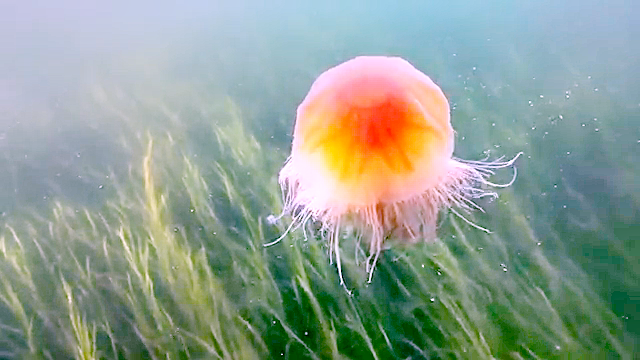

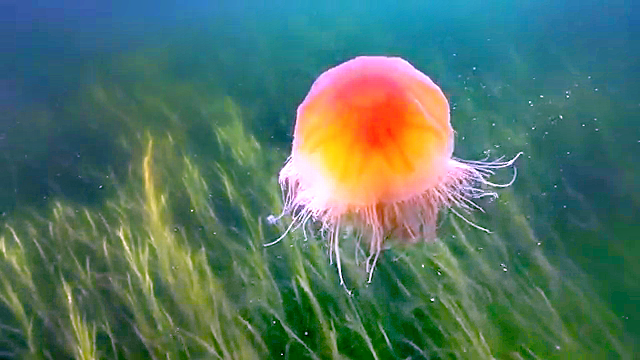

In [ ]:
from google.colab.patches import cv2_imshow
if __name__ == '__main__':
    import sys
    hr = HazeRemoval()
    image=aft
    hr.open_image(image)
    hr.get_dark_channel()
    hr.get_air_light()
    hr.get_transmission()
    hr.guided_filter()
    hr.recover()
    hr.show()
    dark=hr.Dark_Prior()

## **Now spliting the images into Red green and Blue Chennels**

In [ ]:
def SplitRBG(image):
  rbg=[] 
  img = image
  blue, green, red = cv2.split(img)
  re1=cv2.merge((blue,green,red))
  rbg=[red,blue,green]
  return rbg

## **Now passing each RGB Chennel image in SRCNN model and mearge output**

In [ ]:
#dataset = os.path.join(root_dir, "images")
test_path = os.path.join("/content/drive/MyDrive/AI Assignment/input/challenging-60")
#test_path=os.path.join(dataset,'test')
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)

In [ ]:

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    #plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [ ]:

class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [ ]:
from keras.models import load_model
#loading Pretrained SRCNN model
model = tf.keras.Sequential()
model=tf.keras.models.load_model("/content/drive/MyDrive/AI Assignment/my_modelSRCNN.h5")

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf_op_layer_DepthToSpace (Te (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
__________________________________________________

PSNR of low resolution image and high resolution image is 28.3835
PSNR of predict and high resolution is 29.4263


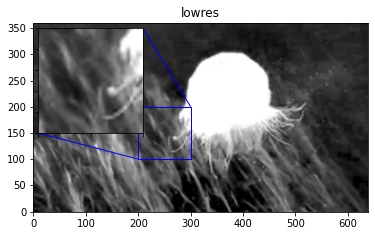

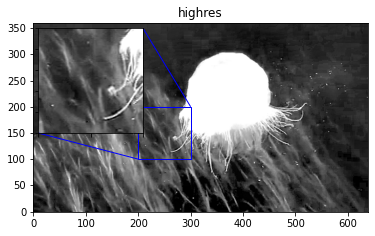

PSNR of low resolution image and high resolution image is 27.6201
PSNR of predict and high resolution is 28.6954


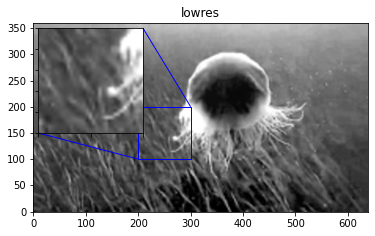

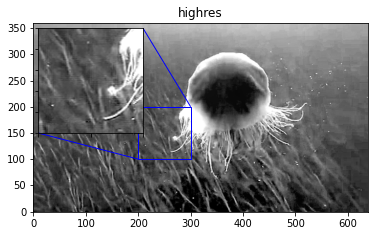

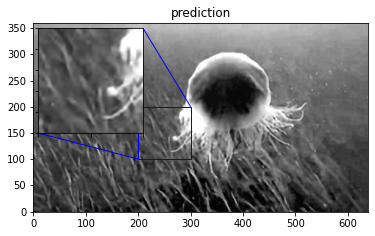

PSNR of low resolution image and high resolution image is 30.7526
PSNR of predict and high resolution is 31.6093


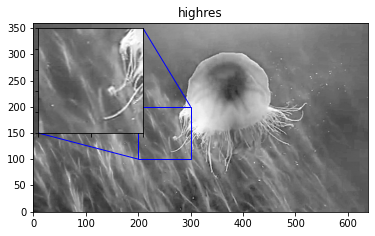

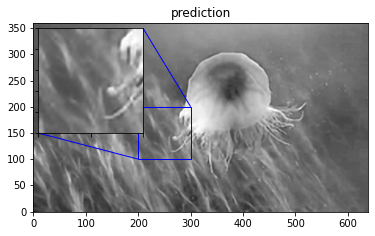

PSNR of low resolution image and high resolution image is 28.3835
PSNR of predict and high resolution is 29.4263


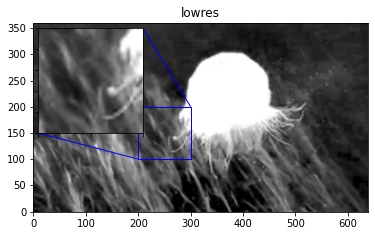

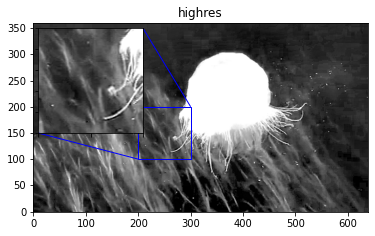

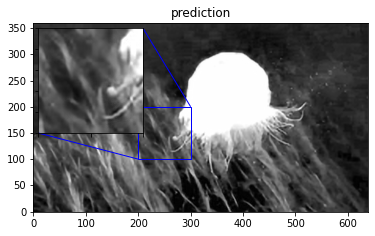

PSNR of low resolution image and high resolution image is 27.6201
PSNR of predict and high resolution is 28.6954


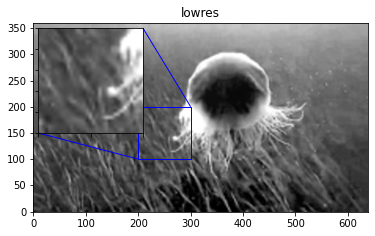

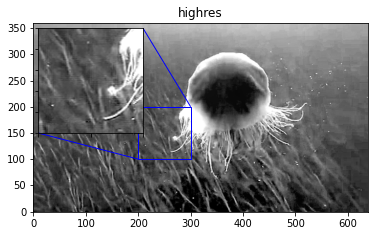

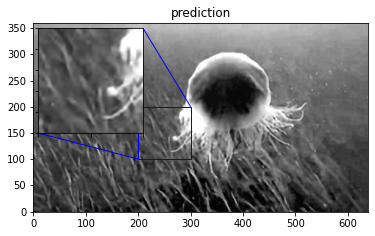

PSNR of low resolution image and high resolution image is 30.7526
PSNR of predict and high resolution is 31.6093


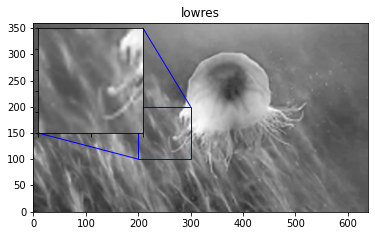

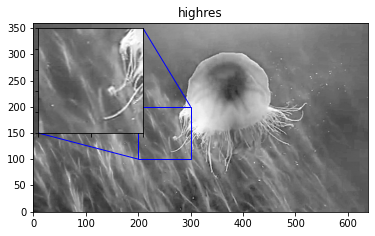

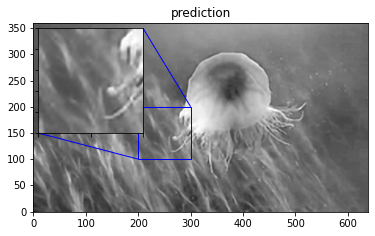

PSNR of low resolution image and high resolution image is 28.3835
PSNR of predict and high resolution is 29.4263


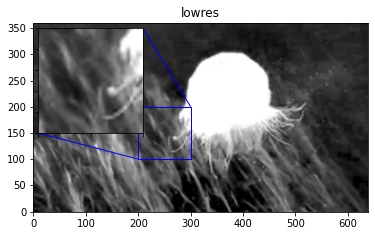

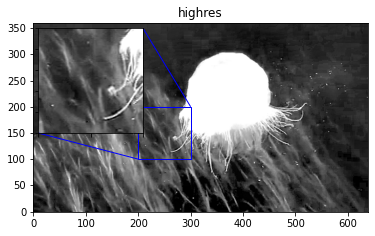

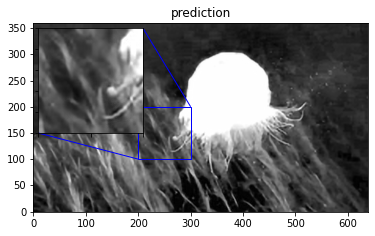

PSNR of low resolution image and high resolution image is 27.6201
PSNR of predict and high resolution is 28.6954


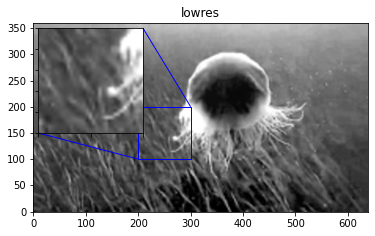

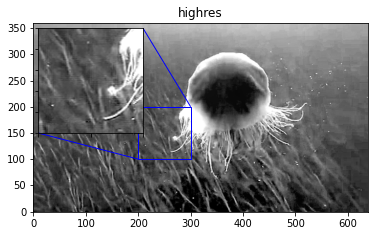

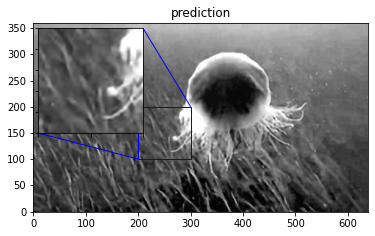

PSNR of low resolution image and high resolution image is 30.7526
PSNR of predict and high resolution is 31.6093


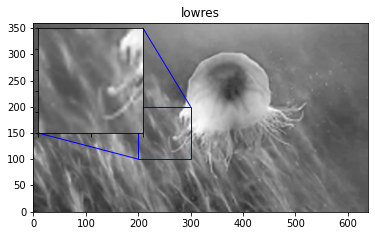

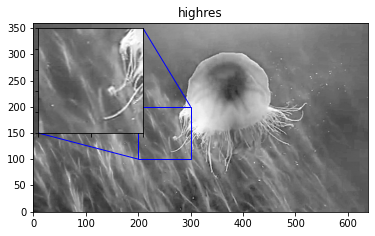

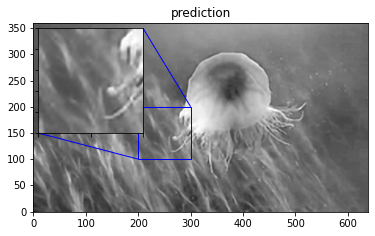

PSNR of low resolution image and high resolution image is 28.3835
PSNR of predict and high resolution is 29.4263


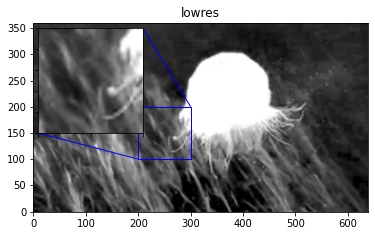

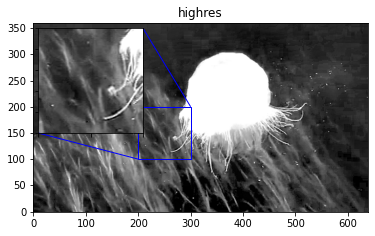

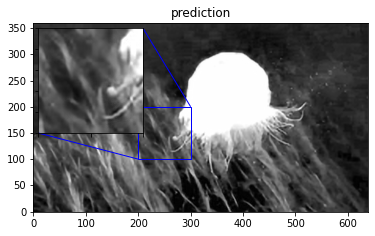

PSNR of low resolution image and high resolution image is 27.6201
PSNR of predict and high resolution is 28.6954


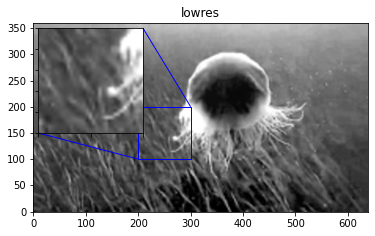

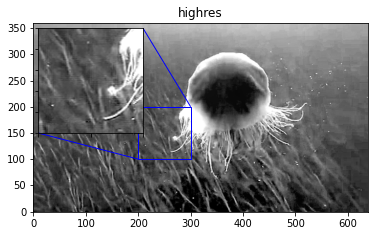

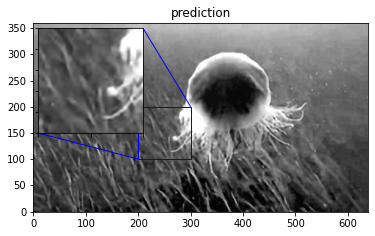

PSNR of low resolution image and high resolution image is 30.7526
PSNR of predict and high resolution is 31.6093


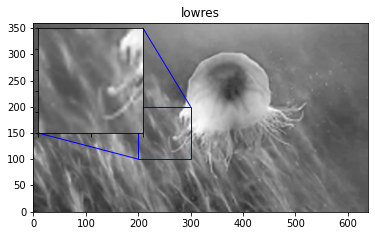

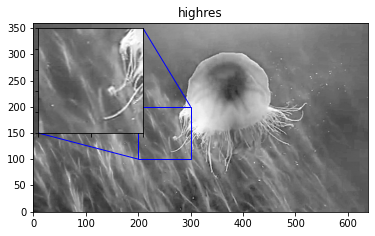

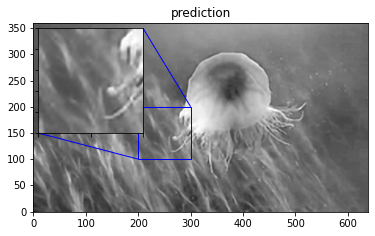

PSNR of low resolution image and high resolution image is 28.3835
PSNR of predict and high resolution is 29.4263


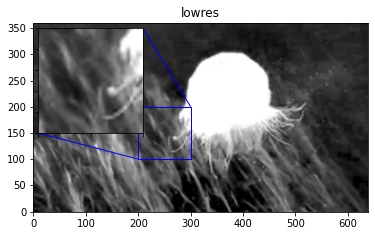

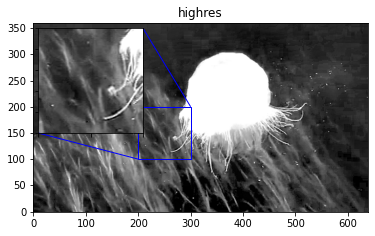

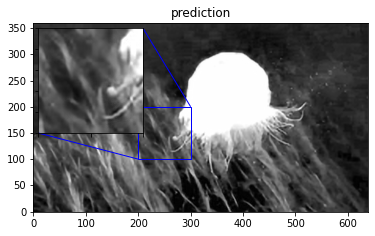

PSNR of low resolution image and high resolution image is 27.6201
PSNR of predict and high resolution is 28.6954


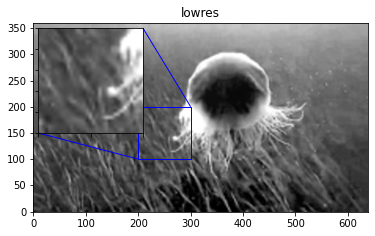

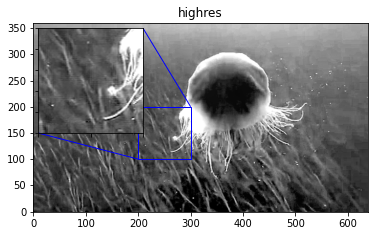

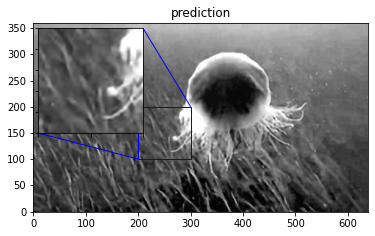

PSNR of low resolution image and high resolution image is 30.7526
PSNR of predict and high resolution is 31.6093


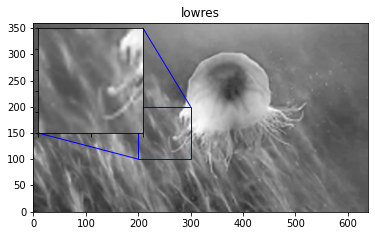

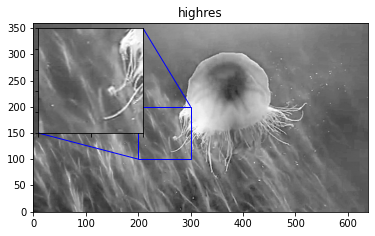

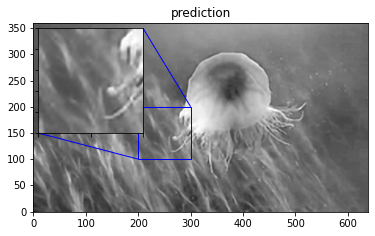

Avg. PSNR of lowres images is 43.3781
Avg. PSNR of reconstructions is 44.8655


In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0
upscale_factor=3
pre_img=[]
arr=[2,5,1,5,9,8,5]
for index, test_img_path in enumerate(arr[0:5]):
    #image by path
    #img = load_img(test_img_path)
  rbg=SplitRBG(dark)
  for i in range(0,3):
      img=Image.fromarray(np.uint8(rbg[i])).convert('RGB')
      lowres_input = get_lowres_image(img, upscale_factor)
      w = lowres_input.size[0] * upscale_factor
      h = lowres_input.size[1] * upscale_factor
      highres_img = img.resize((w, h))
      prediction = upscale_image(model, lowres_input)
      lowres_img = lowres_input.resize((w, h))
      lowres_img_arr = img_to_array(lowres_img)
      highres_img_arr = img_to_array(highres_img)
      predict_img_arr = img_to_array(prediction)
      pre_img.append(highres_img_arr)
      bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
      test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

      total_bicubic_psnr += bicubic_psnr
      total_test_psnr += test_psnr

      print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
        )
      print("PSNR of predict and high resolution is %.4f" % test_psnr)
      plot_results(lowres_img, index, "lowres")
      plot_results(highres_img, index, "highres")
      plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

## After predicting the each chennal merge All chennel and get output 

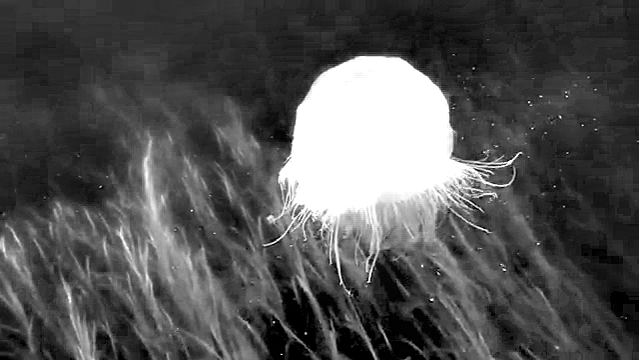

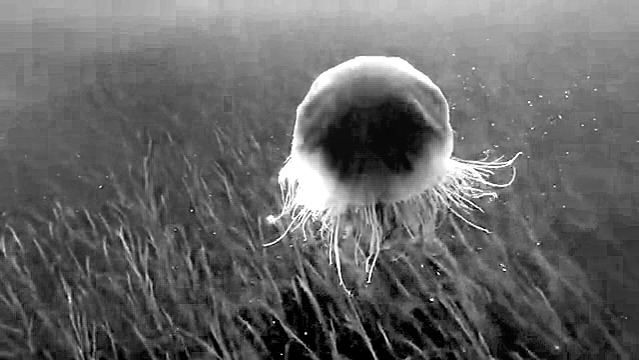

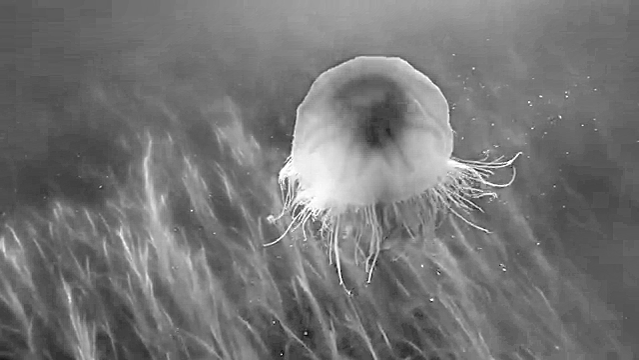

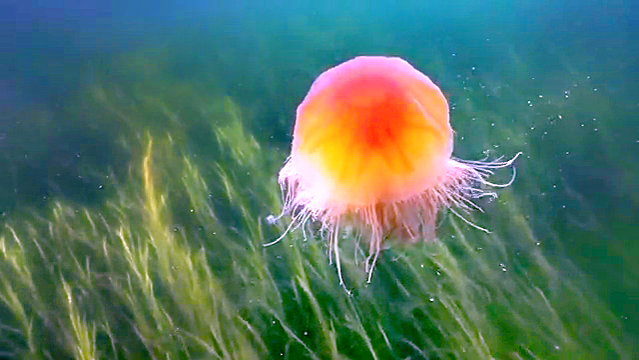

In [ ]:
red,blue,green=pre_img[0],pre_img[1],pre_img[2]
img=red
r = img[:,:,2]
cv2_imshow(r)
r.shape

b=blue[:,:,0]
cv2_imshow(b)

g=green[:,:,1]
cv2_imshow(g)

output=cv2.merge((b,g,r))
cv2_imshow(output)

## output Image

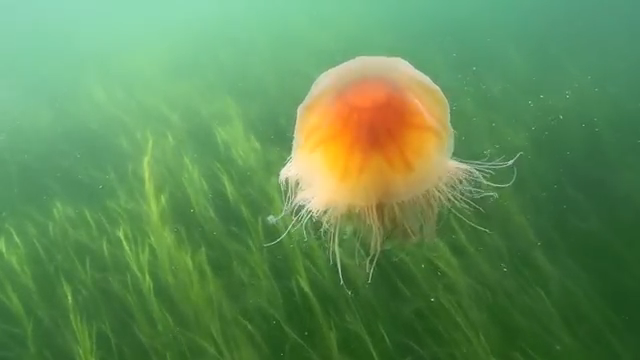

(360, 640, 3)

In [ ]:
cv2_imshow(Orignal_img)
Orignal_img.shape

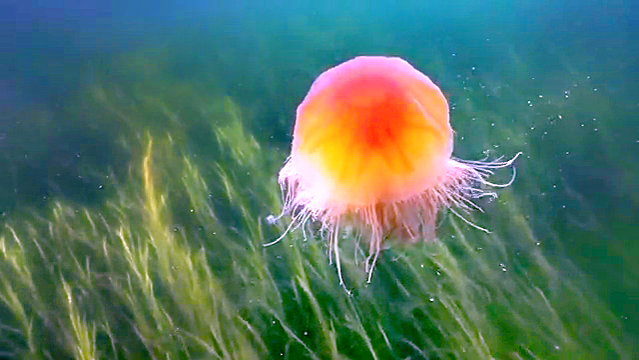

(360, 639, 3)

In [ ]:
cv2_imshow(output)
output.shape

In [ ]:
from math import log10, sqrt 
import cv2 
import numpy as np 

def PSNR(original, compressed): 
	mse = np.mean((original - compressed) ** 2) 
	if(mse == 0): # MSE is zero means no noise is present in the signal . 
				# Therefore PSNR have no importance. 
		return 100
	max_pixel = 255.0
	psnr = 20 * log10(max_pixel / sqrt(mse)) 
	return psnr 

	



In [ ]:
o=np.delete(Orignal_img,639,1)
o.shape

(360, 639, 3)

In [ ]:

original = o
compressed = output
value = PSNR(original, compressed) 
print(f"PSNR value is {value} ") 

PSNR value is 15.135387224955284 


In [ ]:
from skimage.measure import compare_ssim
import argparse
import imutils
import cv2

imageA = o
imageB = output

grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")

print("SSIM: {}".format(score))

SSIM: 0.5460245819947694


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':
